In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
import healpy as hp
from healpy.newvisufunc import projview

In [3]:
sys.executable

'/ext3/miniconda3/bin/python'

### QUaia catalog

In [4]:
quasar_fn = '/scratch/aew492/quasars/catalogs/catalog_G20.0.fits'
data_quaia = Table.read(quasar_fn, format='fits')

In [5]:
nd = len(data_quaia)
nd

755850

### Create random catalog

#### 1. Generate $N$ 3-vectors (randomly distributed across the sphere)

In [6]:
rng = default_rng(seed=19)

In [7]:
rand_vecs = rng.normal(size=(nd,3))

In [8]:
rand_vecs.shape

(755850, 3)

#### 2. Convert $(x,y,z)\rightarrow (\mathrm{RA},\,\mathrm{Dec})$

In [9]:
def xyz_to_thetaphi(xyz):
    x, y, z = xyz
    r = np.linalg.norm(xyz)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    return theta, phi

In [10]:
def thetaphi_to_radec(theta, phi):
    ra = theta * 180/np.pi
    dec = 90 - phi * 180/np.pi
    return ra, dec

In [11]:
def xyz_to_radec(xyz):
    theta, phi = xyz_to_thetaphi(xyz)
    ra, dec = thetaphi_to_radec(theta, phi)
    return ra, dec

In [12]:
thetas, phis = np.array([xyz_to_thetaphi(pos) for pos in rand_vecs]).T

In [13]:
min(thetas), max(thetas), min(phis), max(phis)

(-3.14158116831174,
 3.1415855727960027,
 0.001963580050719392,
 3.1399840360330336)

In [14]:
ra, dec = np.array([xyz_to_radec(pos) for pos in rand_vecs]).T

In [15]:
min(ra), max(ra), min(dec), max(dec)

(-179.99934194204104, 179.99959430040022, -89.907833003147, 89.8874951503577)

#### 3. Plot on the sky

In [16]:
# map of number counts
NSIDE = 256 # 64
NPIX = hp.nside2npix(NSIDE)
pixel_indices_rand = hp.ang2pix(NSIDE, ra, dec, lonlat=True)
map_rand = np.bincount(pixel_indices_rand, minlength=NPIX)

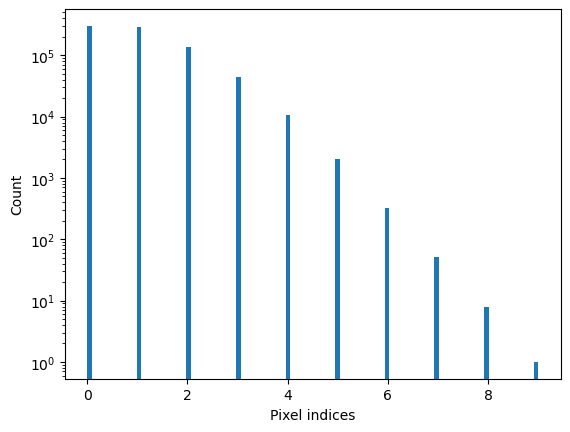

In [17]:
_, _, _ = plt.hist(map_rand, bins=100)
plt.xlabel('Pixel indices')
plt.ylabel('Count')
# plt.xscale('log')
plt.yscale('log')

In [18]:
np.median(map_rand), np.std(map_rand)

(1.0, 0.9808193400689388)

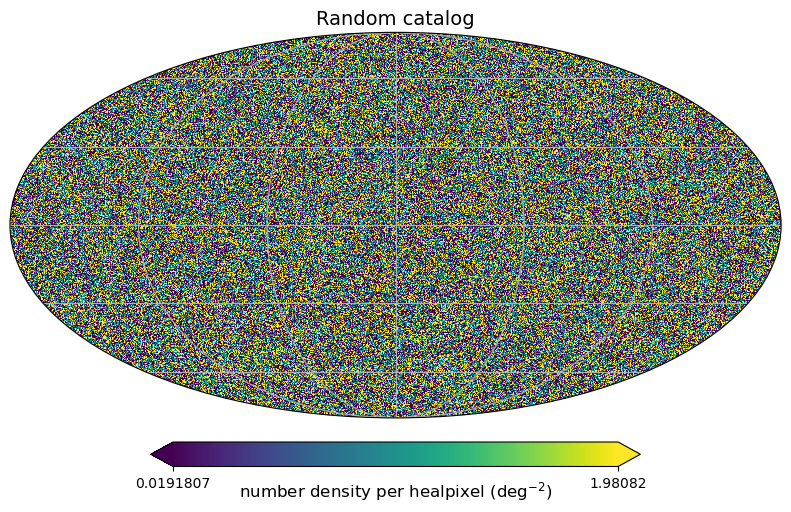

In [19]:
projview(map_rand, title='Random catalog', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True,
        min=np.median(map_rand)-np.std(map_rand), max=np.median(map_rand)+np.std(map_rand))

#### 4. compute dipole

In [20]:
# fit monopole and dipole:
map_rand_flt = [float(pix) for pix in map_rand]  # need to convert to this form otherwise remove_dipole() throws error
map_nodip, monop, dip = hp.pixelfunc.remove_dipole(map_rand_flt, fitval=True)
# direction
lon, lat = hp.rotator.vec2dir(dip, lonlat=True)
# amplitude
dipamp = np.linalg.norm(dip)
print(f"monopole: {monop:.6f}")
print(f"dipole: {dip}")
print(f"  dir ({lon:.3f}, {lat:.3f}), amplitude {dipamp:.6f}")

monopole: 0.961113
dipole: [-0.00160757  0.00116283  0.00011025]
  dir (144.120, 3.181), amplitude 0.001987


In [21]:
minn = np.median(map_nodip)-2*np.std(map_nodip)
maxn = np.median(map_nodip)+2*np.std(map_nodip)

/ext3/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


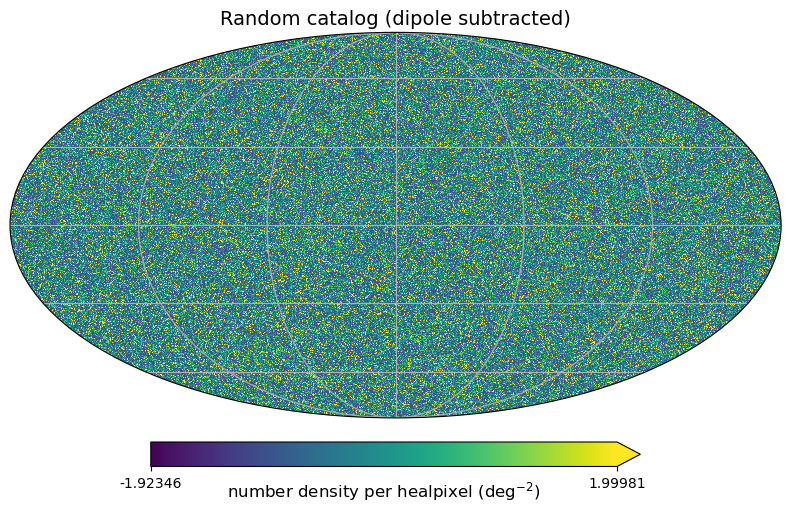

In [22]:
projview(map_nodip, title='Random catalog (dipole subtracted)', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True,
         min=minn, max=maxn) 

### Compute dipole with different random seeds to check spread

In [23]:
def compute_dipole(rng, NSIDE=64):
    rand_vecs = rng.normal(size=(nd,3))
    ra, dec = np.array([xyz_to_radec(pos) for pos in rand_vecs]).T
    pix_idx_rand = hp.ang2pix(NSIDE, ra, dec, lonlat=True)
    map_rand = np.bincount(pix_idx_rand, minlength=NPIX)
    map_rand_flt = [float(pix) for pix in map_rand]  # need to convert to this form otherwise remove_dipole() throws error
    map_nodip, monop, dip = hp.pixelfunc.remove_dipole(map_rand_flt, fitval=True)
    # direction
    lon, lat = hp.rotator.vec2dir(dip, lonlat=True)
    # amplitude
    dipamp = np.linalg.norm(dip)
    print(f"monopole: {monop:.6f}")
    print(f"dipole: {dip}")
    print(f"  dir ({lon:.3f}, {lat:.3f}), amplitude {dipamp:.6f}")
    print("")
    return lon, lat, dipamp

In [24]:
ntrials = 10
dirs = []
amps = []
for i in range(ntrials):
    rng = default_rng()
    lon, lat, amp = compute_dipole(rng, NSIDE=64)
    dirs.append([lon,lat])
    amps.append(amp)

monopole: 0.961113
dipole: [1.33035784e-03 5.42165008e-03 2.70312239e+00]
  dir (76.213, 89.882), amplitude 2.703128

monopole: 0.961113
dipole: [3.12037291e-03 1.83402931e-03 2.70312877e+00]
  dir (30.445, 89.923), amplitude 2.703131

monopole: 0.961113
dipole: [2.03406065e-03 1.83509078e-03 2.70322690e+00]
  dir (42.056, 89.942), amplitude 2.703228

monopole: 0.961113
dipole: [0.00270878 0.00330046 2.70324454]
  dir (50.623, 89.910), amplitude 2.703248

monopole: 0.961113
dipole: [0.0044645  0.00274069 2.70300692]
  dir (31.545, 89.889), amplitude 2.703012

monopole: 0.961113
dipole: [0.00310458 0.00288473 2.70304782]
  dir (42.898, 89.910), amplitude 2.703051

monopole: 0.961113
dipole: [4.40969536e-03 2.61220590e-03 2.70314876e+00]
  dir (30.642, 89.891), amplitude 2.703154

monopole: 0.961113
dipole: [0.00288901 0.00446377 2.70301678]
  dir (57.088, 89.887), amplitude 2.703022

monopole: 0.961113
dipole: [2.12484922e-03 3.80795354e-03 2.70316669e+00]
  dir (60.838, 89.908), amplit